In [1]:
from acfunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from IPython.display import Image, display, HTML
import starspot as ss
import starspot.rotation_tools as rt
from starspot import sigma_clipping
import lightkurve as lk
from lightkurve import search_targetpixelfile, search_lightcurvefile
import math
import exoplanet
import eleanor
from astropy.coordinates import SkyCoord
from scipy import interpolate
from tess_kep_funct import *
from tqdm import tqdm
from scipy import misc
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [5]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [6]:
# converting txt file data to arrays
tic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    mcq_periods.append(float(rot_table[index][2]))

In [7]:
def find_m_b(x,y,err): #analytical approach to finding line of best fit 
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error): #residual abundance function
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

In [8]:
#list of stars in tess with two minute cadences
with open('two_result.data', 'rb') as filehandle:
    search_result_two = pickle.load(filehandle)

#stars with thirty minute cadences
with open('thirty_result.data', 'rb') as filehandle:
    search_result_thirty = pickle.load(filehandle)

#names of stars with thirty minute cadences
with open('thirty_m_cadence.data', 'rb') as filehandle:
    thirty_m_cadence = pickle.load(filehandle)
    
#names of stars with two minute cadences
with open('two_m_cadence.data', 'rb') as filehandle:
    two_m_cadence = pickle.load(filehandle)

# doing all the functions on solar twin stars !

star_lk = (search_result_two[0]).download_all(quality_bitmask='default')
tick = star_lk[0].targetid

star = eleanor.Source(tic=tick)
data = eleanor.TargetData(star, do_psf=True, do_pca=True)

q = data.quality == 0
time = data.time[q] 
flux_nan = (data.pca_flux[q])[~np.isnan(data.pca_flux[q])]
norm_flux = data.pca_flux[q]/np.nanmedian(data.pca_flux[q])
    
mask = (time <= 1696) & (time >= 1692)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]

mask_2 = (time_masked <= 1708) & (time_masked >= 1705)
norm_flux = norm_flux_2[~mask_2]
time = time_masked[~mask_2]

norm_flux_err = np.sqrt(norm_flux)
                        
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
#linear interpolation
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)
    
plt.plot(xnew, flux, 'k')
       
#exo acf
ex_1 = exoplanet.autocorr_estimator(xnew, flux, yerr= flux_err, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period'] 
print(exo_period)
        
        
#lomb-scargle 
rotate_el = ss.RotationModel(xnew, flux, flux_err)
ls_period = rotate_el.ls_rotation()
print(ls_period)
        
#pdm 
period_grid = np.linspace(.1, 10, 1000)
pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)
print(pdm_period)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1000/1000 [00:00<00:00, 2037.65it/s]


fitting to a limited range
works!


error
error


error


100%|██████████| 1000/1000 [00:00<00:00, 1430.23it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1856.37it/s]


works!
error
error


100%|██████████| 1000/1000 [00:00<00:00, 1167.83it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1466.02it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:00<00:00, 1460.69it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1331.90it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1338.79it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 527.71it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:00<00:00, 1365.72it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1336.03it/s]


works!


100%|██████████| 968/968 [00:18<00:00, 51.37it/s]


error


100%|██████████| 1000/1000 [00:00<00:00, 1327.10it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1973.29it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1978.34it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:00<00:00, 1389.80it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1588.42it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1871.55it/s]


works!


100%|██████████| 1248/1248 [00:25<00:00, 49.18it/s]


error
error


100%|██████████| 1248/1248 [01:11<00:00, 17.40it/s]


error


100%|██████████| 1000/1000 [00:00<00:00, 1043.63it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1872.64it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1198.59it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1120.73it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1574.77it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1240.60it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 2011.98it/s]


works!


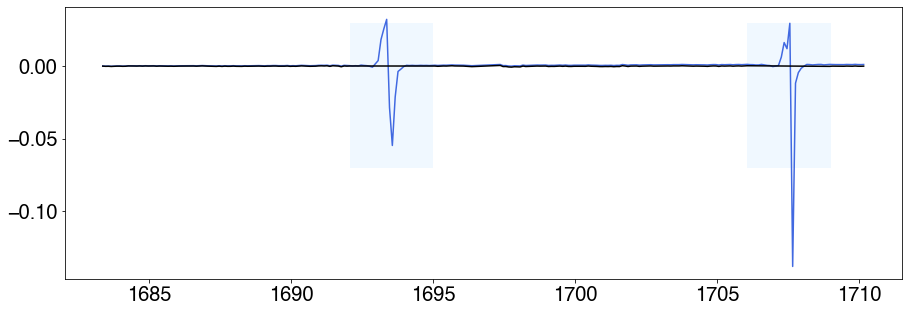

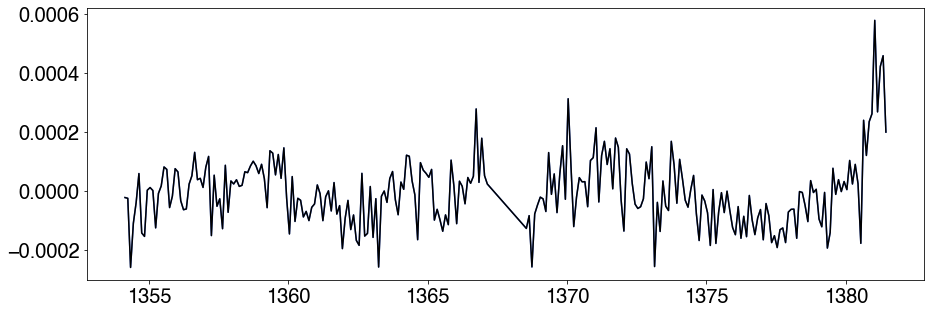

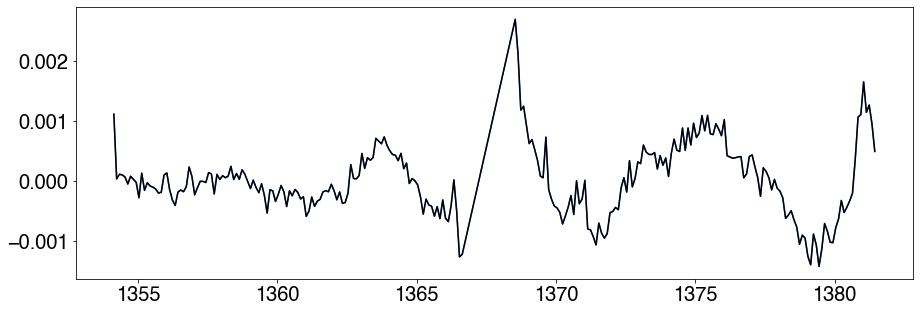

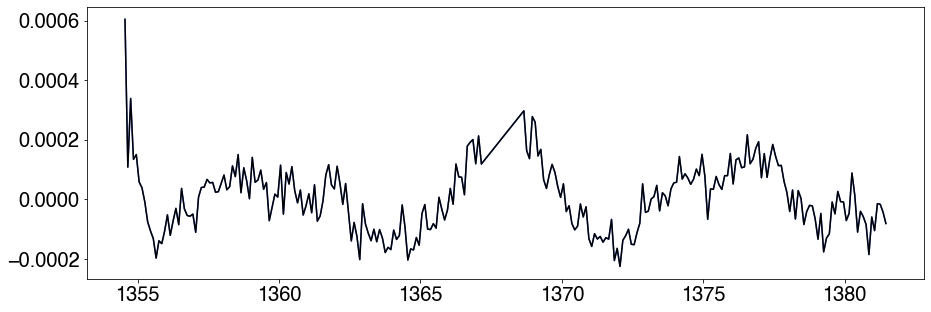

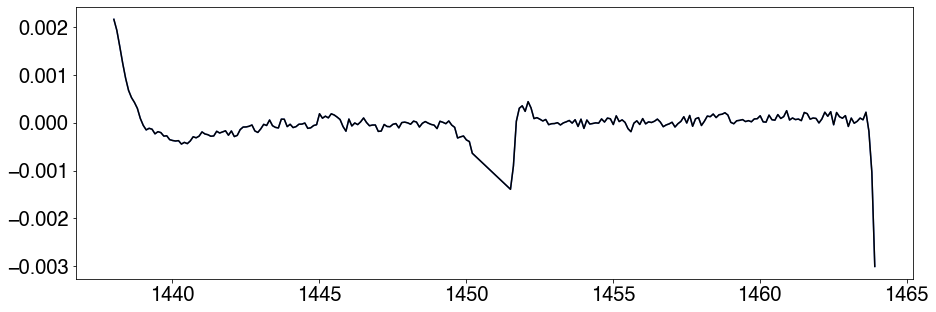

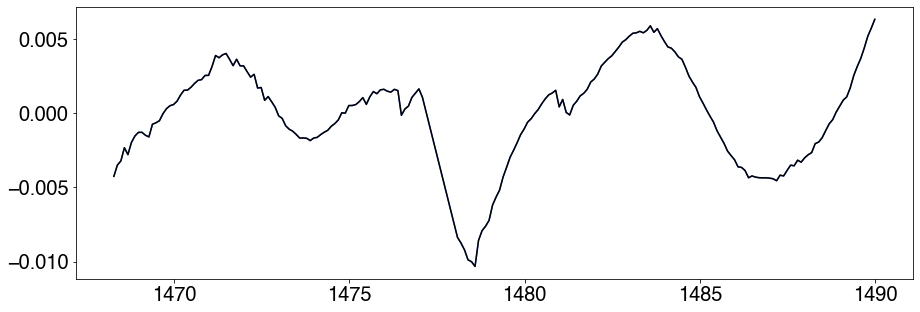

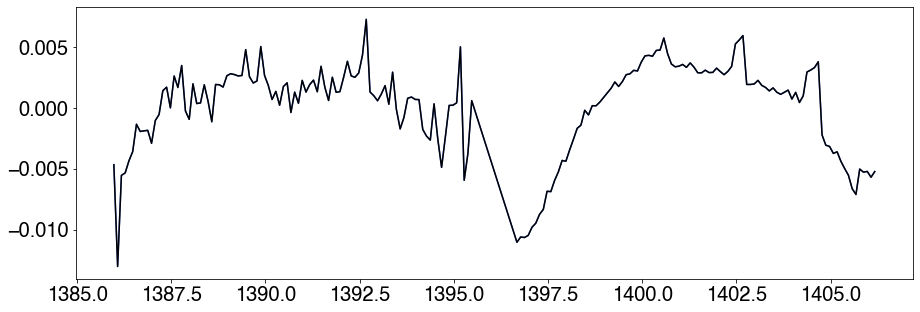

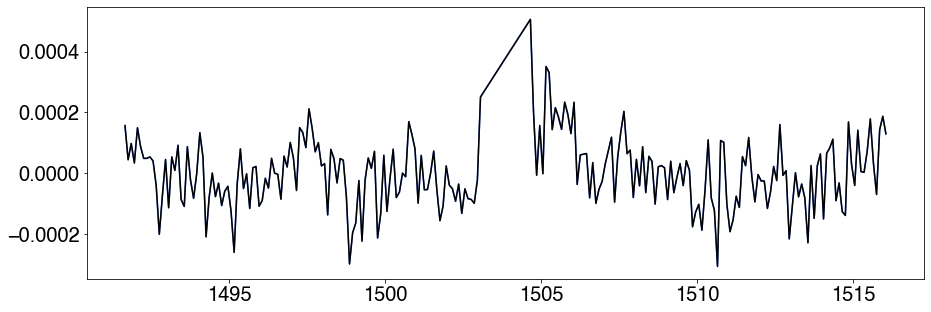

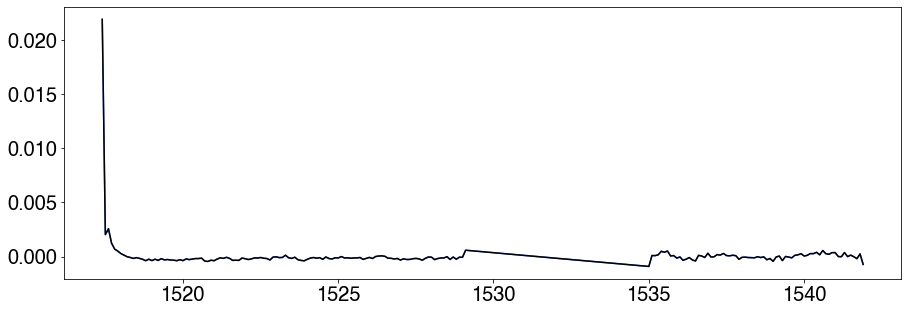

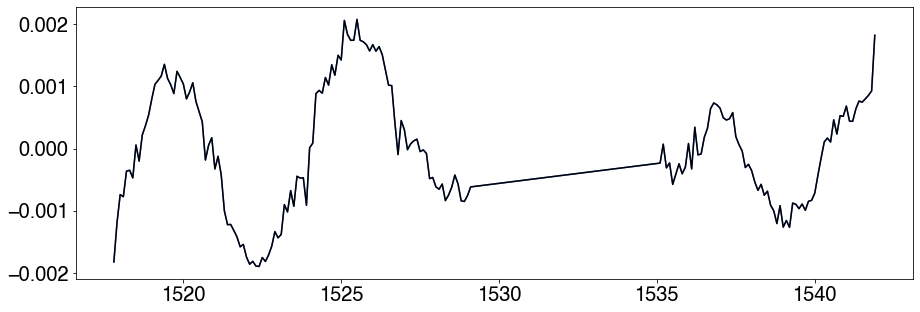

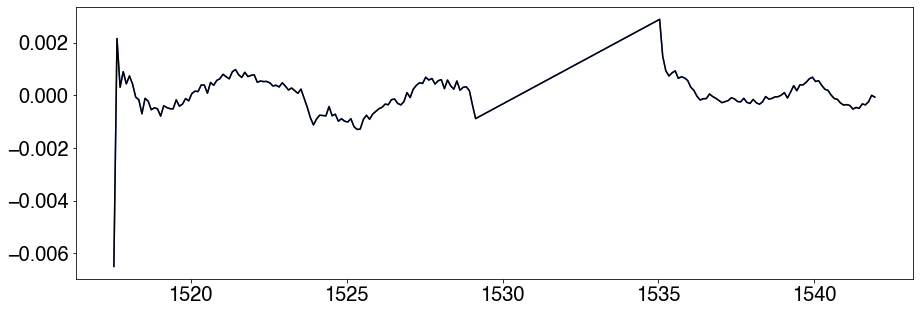

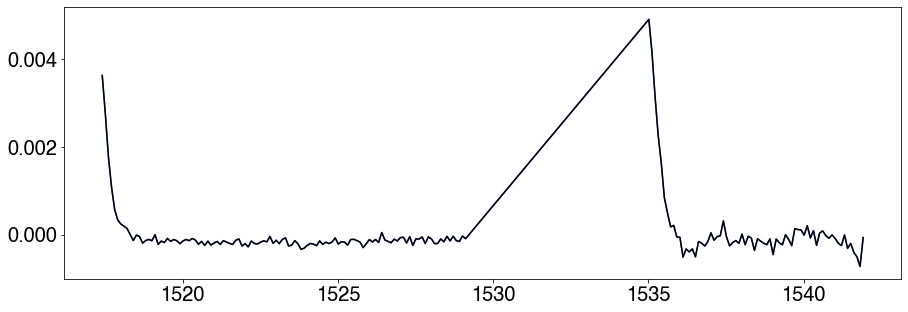

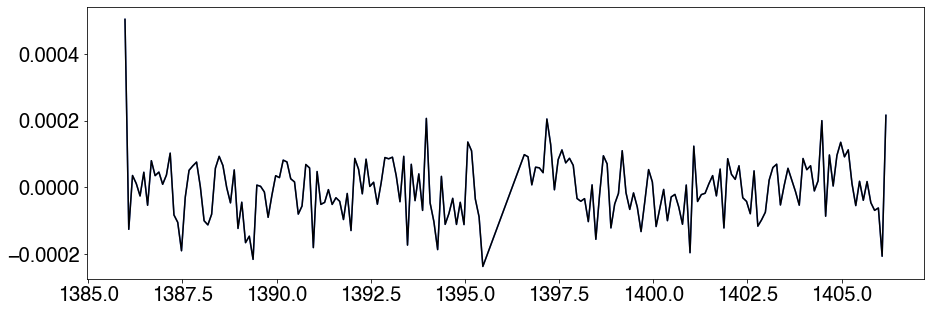

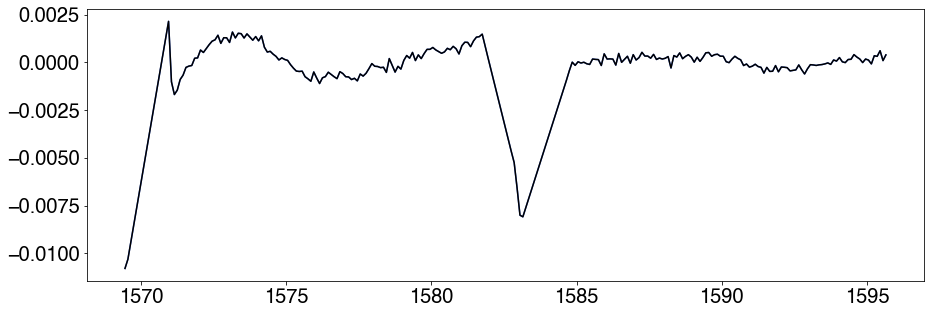

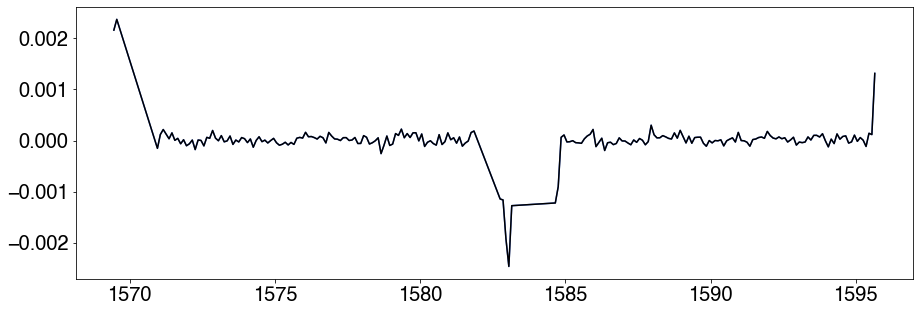

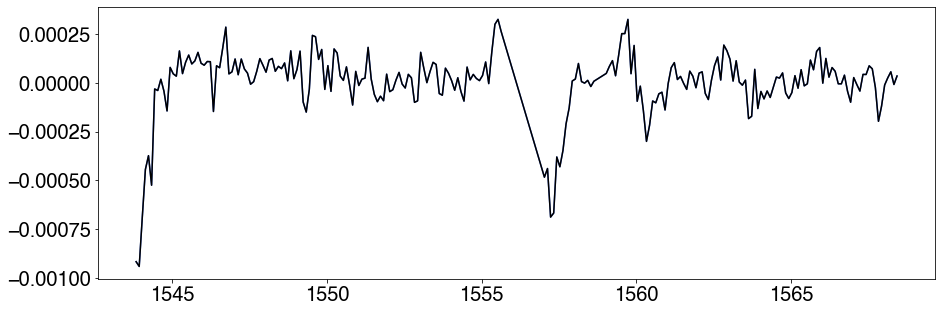

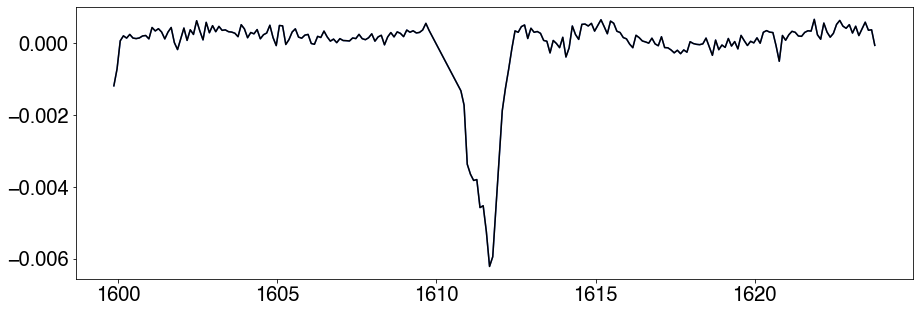

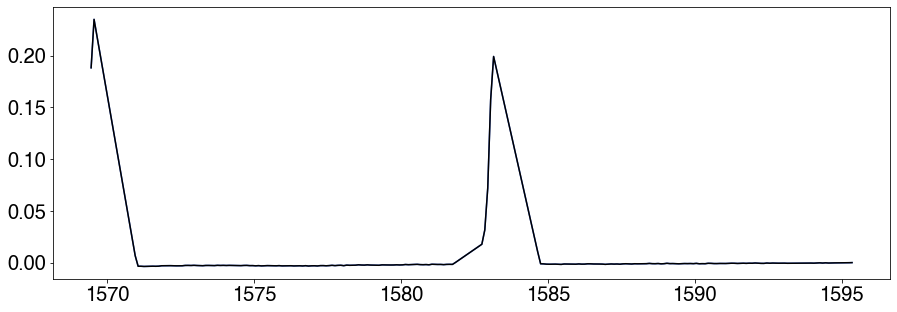

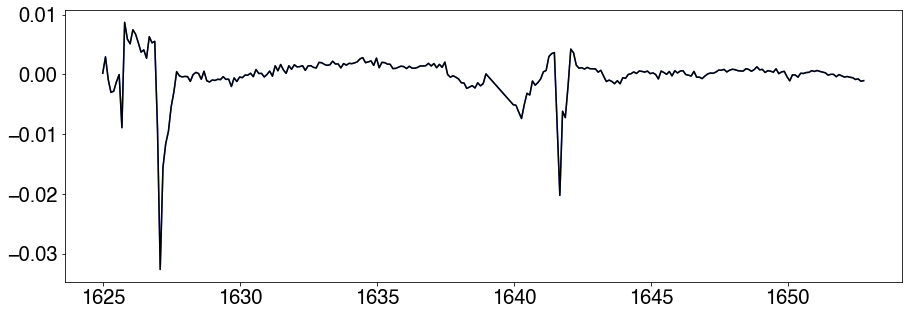

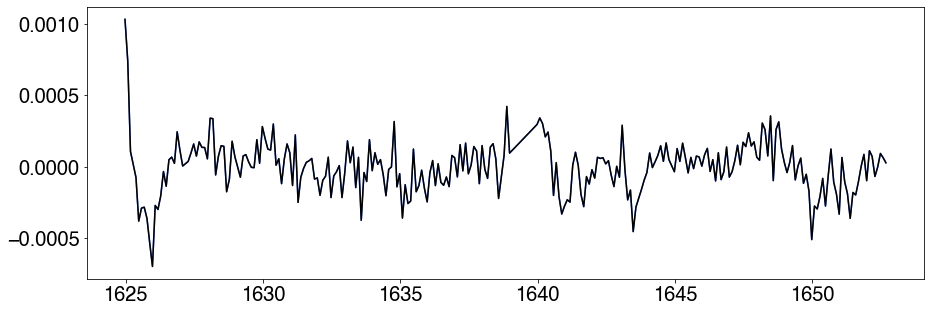

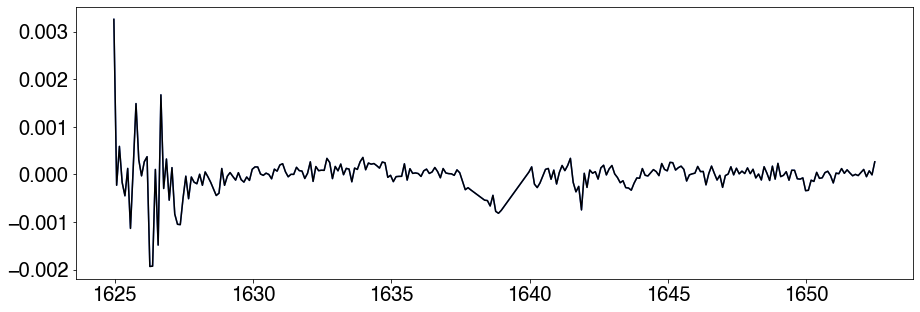

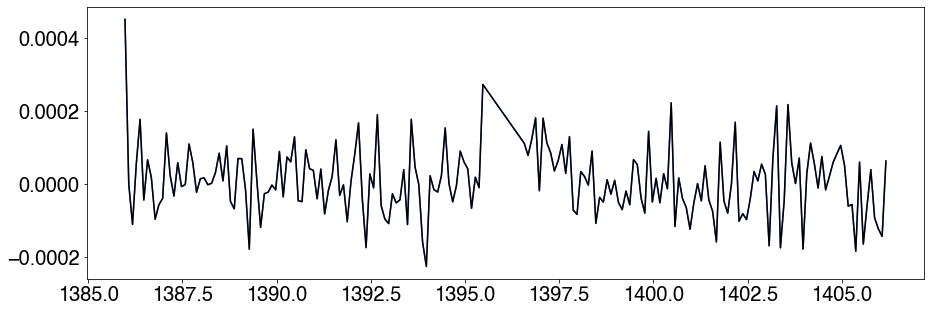

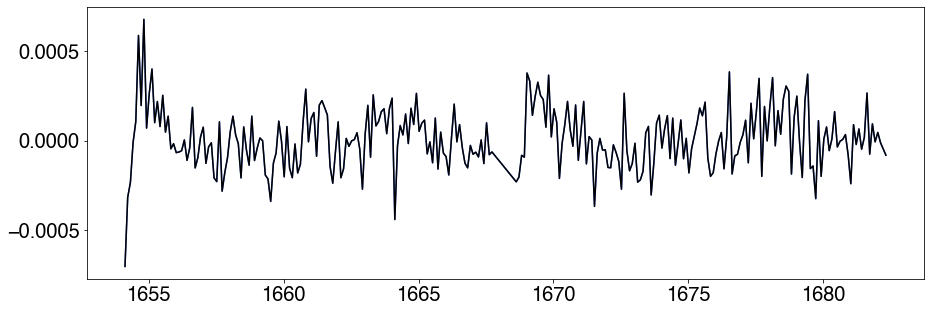

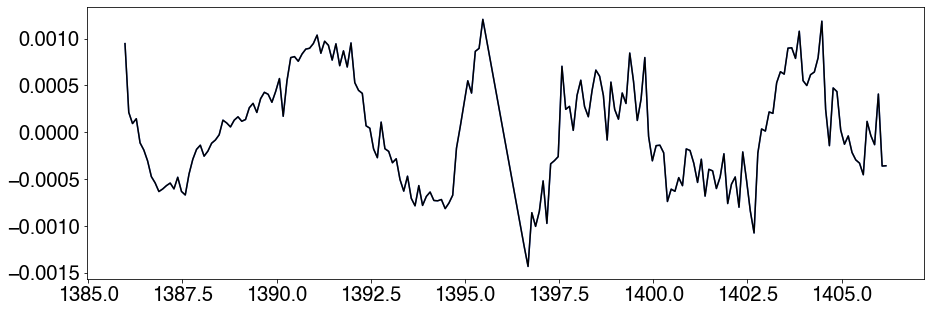

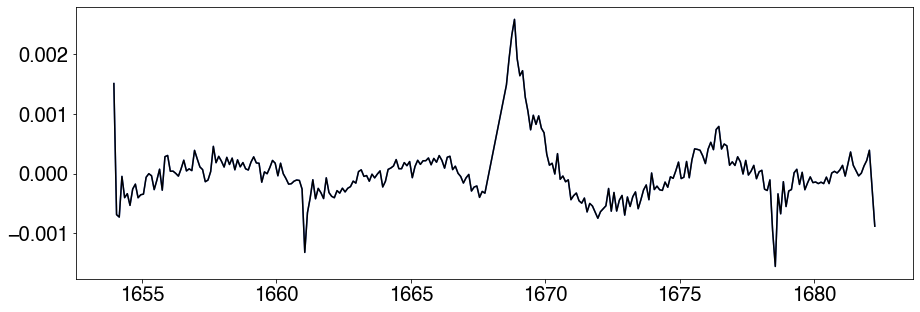

In [12]:
ls_young_stars = []
pdm_young_stars = []
exo_young_stars = []

for each, tic in enumerate(search_result_two): 
    star_lk = (tic).download_all(quality_bitmask='default')
    tick = star_lk[0].targetid

    try:
        star = eleanor.Source(tic=tick)
        data = eleanor.TargetData(star, do_psf=True, do_pca=True)

        q = data.quality == 0
        time = data.time[q] 
        flux_nan = (data.pca_flux[q])[~np.isnan(data.pca_flux[q])]
        norm_flux = flux_nan/np.nanmedian(data.pca_flux[q])
        
        #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1692)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1706)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1692) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1706) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('solar_twin_flux_{0}.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_young_stars.append(exo_period)

        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew_mask, flux_mask, flux_err_mask)
        ls_period = rotate_el.ls_rotation()
        ls_young_stars.append(ls_period)
       
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)    
        pdm_young_stars.append(pdm_period)
        print('works!')
        
    except : 
        print('error')
        ls_young_stars.append(0)
        pdm_young_stars.append(0)
        exo_young_stars.append(0)

(array([9., 0., 1., 5., 6., 2., 3., 3., 1., 3.]),
 array([ 0.        ,  1.60225536,  3.20451071,  4.80676607,  6.40902143,
         8.01127679,  9.61353214, 11.2157875 , 12.81804286, 14.42029821,
        16.02255357]),
 <a list of 10 Patch objects>)

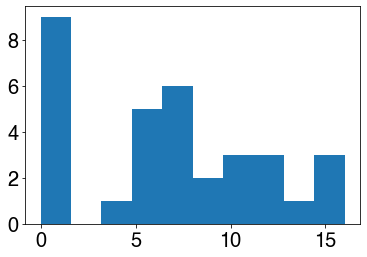

In [14]:
plt.hist(ls_young_stars)

(array([10.,  0.,  0.,  1.,  0.,  1.,  8.,  2.,  4.,  7.]),
 array([0.        , 0.99801802, 1.99603604, 2.99405405, 3.99207207,
        4.99009009, 5.98810811, 6.98612613, 7.98414414, 8.98216216,
        9.98018018]),
 <a list of 10 Patch objects>)

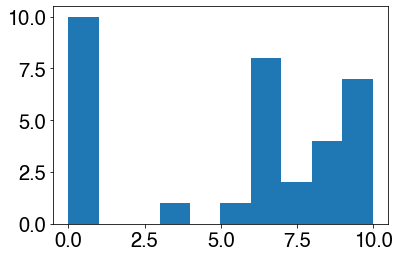

In [15]:
plt.hist(pdm_young_stars)

(array([10.,  5.,  5.,  3.,  3.,  1.,  1.,  1.,  2.,  2.]),
 array([ 0.   ,  1.355,  2.71 ,  4.065,  5.42 ,  6.775,  8.13 ,  9.485,
        10.84 , 12.195, 13.55 ]),
 <a list of 10 Patch objects>)

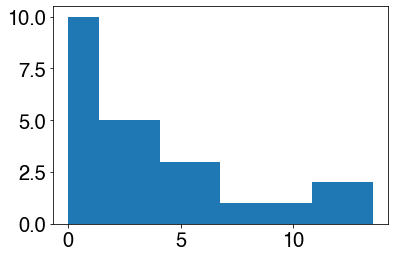

In [16]:
plt.hist(exo_young_stars)

In [17]:
mcq_young_stars = []
for each, tic in enumerate(search_result_two): 
    star_lk = (tic).download_all(quality_bitmask='default')
    tick = star_lk[0].targetid

    index = np.where(np.array(tic_ids) == tick)
    
    try: 
        mcq_period = mcq_periods[index[0][0]]
        mcq_young_stars.append(mcq_period)
        
    except: 
        mcq_young_stars.append(0)

In [18]:
print(mcq_young_stars)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 1000/1000 [00:00<00:00, 2206.47it/s]


fitting to a limited range
works!


100%|██████████| 993/993 [00:20<00:00, 47.93it/s]


error


100%|██████████| 1000/1000 [00:00<00:00, 1891.46it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1540.52it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 2024.39it/s]


fitting to a limited range
works!


100%|██████████| 968/968 [00:14<00:00, 65.16it/s]


error


100%|██████████| 1000/1000 [00:01<00:00, 998.92it/s]


works!


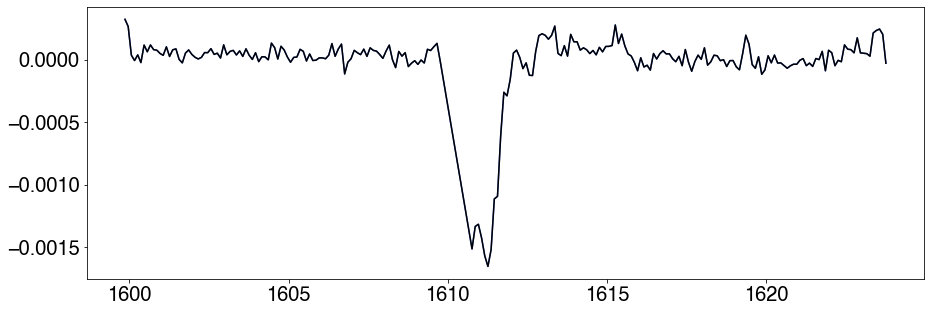

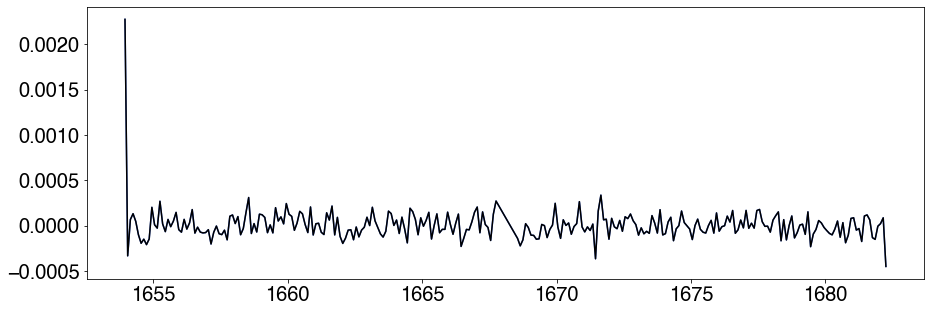

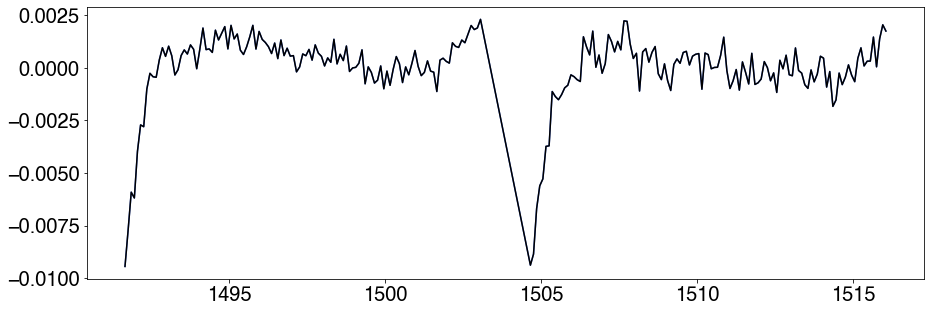

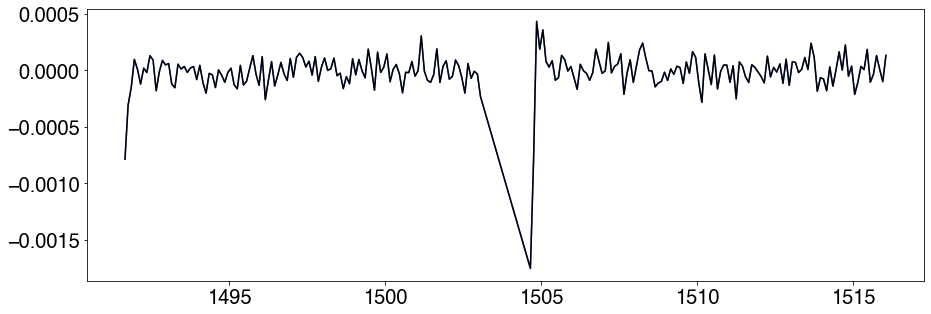

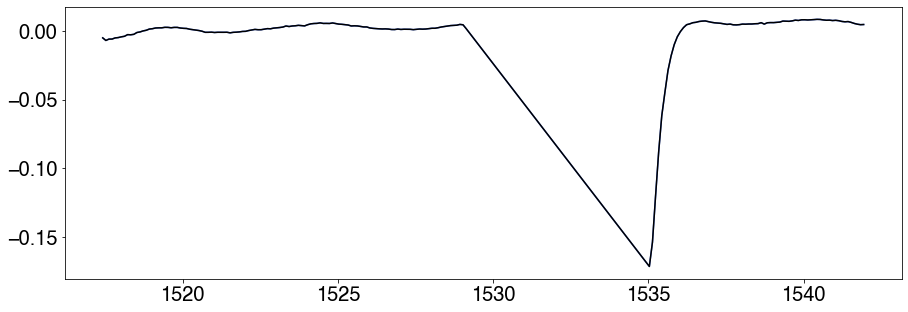

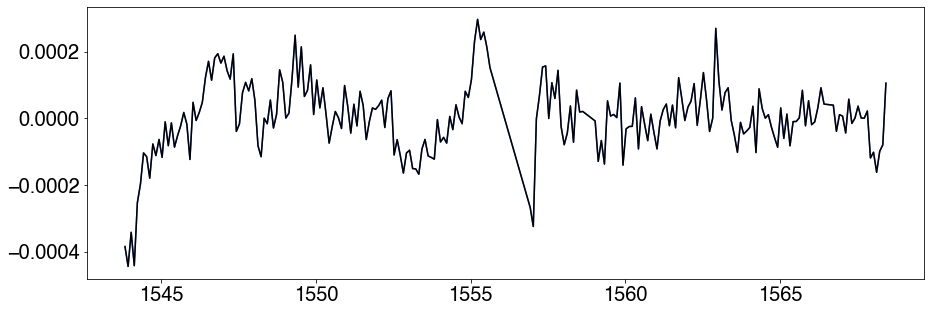

In [13]:
ls_young_stars_thirty = []
pdm_young_stars_thirty = []
exo_young_stars_thirty = []

for each, tic in enumerate(search_result_thirty): 
    star_lk = (tic).download_all(quality_bitmask='default')
    tick = star_lk[0].targetid

    try:
        star = eleanor.Source(tic=tick)
        data = eleanor.TargetData(star, do_psf=True, do_pca=True)

        q = data.quality == 0
        time = data.time[q] 
        flux_nan = (data.pca_flux[q])[~np.isnan(data.pca_flux[q])]
        norm_flux = flux_nan/np.nanmedian(data.pca_flux[q])
        
        #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1692)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1706)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1692) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1706) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('solar_twin_flux_{0}.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_young_stars_thirty.append(exo_period)

        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew_mask, flux_mask, flux_err_mask)
        ls_period = rotate_el.ls_rotation()
        ls_young_stars_thirty.append(ls_period)
       
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)    
        pdm_young_stars_thirty.append(pdm_period)
        print('works!')
        
        
    except : 
        print('error')
        ls_young_stars_thirty.append(0)
        pdm_young_stars_thirty.append(0)
        exo_young_stars_thirty.append(0)

(array([2., 0., 1., 1., 1., 0., 0., 0., 0., 2.]),
 array([ 0.        ,  1.60327263,  3.20654527,  4.8098179 ,  6.41309053,
         8.01636316,  9.6196358 , 11.22290843, 12.82618106, 14.4294537 ,
        16.03272633]),
 <a list of 10 Patch objects>)

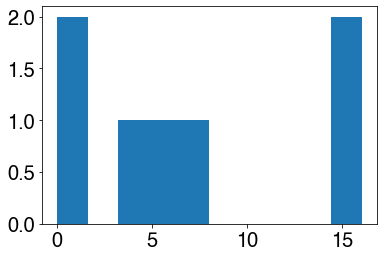

In [19]:
plt.hist(ls_young_stars_thirty)

(array([3., 0., 1., 0., 0., 0., 0., 1., 0., 2.]),
 array([0.        , 0.82954955, 1.6590991 , 2.48864865, 3.3181982 ,
        4.14774775, 4.9772973 , 5.80684685, 6.6363964 , 7.46594595,
        8.2954955 ]),
 <a list of 10 Patch objects>)

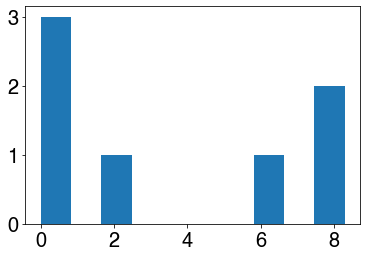

In [20]:
plt.hist(pdm_young_stars_thirty)

(array([2., 1., 0., 0., 0., 1., 0., 0., 2., 1.]),
 array([0.  , 0.56, 1.12, 1.68, 2.24, 2.8 , 3.36, 3.92, 4.48, 5.04, 5.6 ]),
 <a list of 10 Patch objects>)

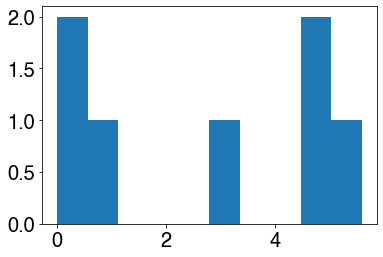

In [21]:
plt.hist(exo_young_stars_thirty)